In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import log1p, col
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/08/23 14:08:00 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.11.182 instead (on interface en0)
24/08/23 14:08:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/23 14:08:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/23 14:08:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sdf = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/curated3')

In [4]:
sdf_sampled = sdf.sample(0.01, seed=1003)
df = sdf_sampled.toPandas()

24/08/23 14:08:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
epsilon = 1e-8
sdf_transformed = sdf

skewed_columns = ['tip_amount', 'trip_duration_mins', 'trip_distance', 'avg_temp', 'precipitation']

for col_name in skewed_columns:
    sdf_transformed = sdf_transformed.withColumn(col_name, log1p(col(col_name) + epsilon))

sdf_transformed.limit(15)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins,pickup_hour,pickup_dayofweek,dropoff_hour,dropoff_dayofweek,days_since_2022_11_01,distance_time_interaction,is_airport_trip,is_tourist_trip,pickup_at_airport,dropoff_at_airport,pickup_at_tourist_attraction,dropoff_at_tourist_attraction,is_holiday_season,is_event_day,avg_temp,precipitation
1,2022-11-01 01:57:31,2022-11-01 02:22:02,1.0,1.8245492936639491,1.0,0,114,50,1,20.0,3.0,0.5,1.9459101504838847,0.0,0.3,29.8,2.5,0.0,3.239331833827484,1,3,2,3,0,5.2,0,1,0,0,1,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 07:36:49,2022-11-01 07:52:15,1.0,1.0296194207525868,1.0,0,141,43,2,11.5,2.5,0.5,9.999999950000001E-9,0.0,0.3,14.8,2.5,0.0,2.799311792989054,7,3,7,3,0,12.6,0,1,0,0,0,1,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 10:44:22,2022-11-01 11:04:24,1.0,1.0296194207525868,1.0,0,229,137,1,13.0,2.5,0.5,1.6193882452674664,0.0,0.3,20.35,2.5,0.0,3.046108481354494,10,3,11,3,0,18.0,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 13:20:22,2022-11-01 14:00:47,1.0,2.939161922594697,1.0,0,88,149,1,52.0,2.5,0.5,2.4890646607665396,0.0,0.3,66.35,2.5,0.0,3.723683376550077,13,3,14,3,0,232.7,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 13:52:00,2022-11-01 14:07:41,1.0,0.6418538914355527,1.0,0,48,186,1,10.0,2.5,0.5,1.294727170334126,0.0,0.3,15.95,2.5,0.0,2.8144102176925205,13,3,14,3,0,11.700000000000001,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 14:28:54,2022-11-01 14:47:07,1.0,0.916290735874155,1.0,0,229,263,1,12.0,2.5,0.5,1.4011829760766954,0.0,0.3,18.36,2.5,0.0,2.95577795856734,14,3,14,3,0,21.0,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 15:19:05,2022-11-01 15:50:06,1.0,1.7917594708947218,1.0,0,230,13,3,21.0,2.5,0.5,9.999999950000001E-9,0.0,0.3,24.3,2.5,0.0,3.4662566008587934,15,3,15,3,0,75.0,0,1,0,0,1,1,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 16:08:35,2022-11-01 16:21:51,1.0,1.0647107404407041,1.0,0,142,246,1,10.5,3.5,0.5,1.3762440277916417,0.0,0.3,17.76,2.5,0.0,2.657925814620576,16,3,16,3,0,30.4,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 17:57:37,2022-11-01 18:08:45,1.0,0.8754687415205665,1.0,0,233,79,1,8.5,3.5,0.5,1.2669476063042258,0.0,0.3,15.35,2.5,0.0,2.495956486798761,17,3,18,3,0,23.799999999999997,0,0,0,0,0,0,0,0,4.182050142793878,0.19062036787311248
1,2022-11-01 18:16:59,2022-11-01 18:49:08,1.0,1.6292405416910642,1.0,0,230,148,1,20.5,3.5,0.5,1.9740810274108984,0.0,0.3,31.0,2.5,0.0,3.5010427169335308,18,3,18,3,0,73.8,0,1,0,0,1,0,0,0,4.182050142793878,0.19062036787311248


In [8]:
sdf_sampled = sdf_transformed.sample(0.01, seed=1003)
df = sdf_sampled.toPandas()

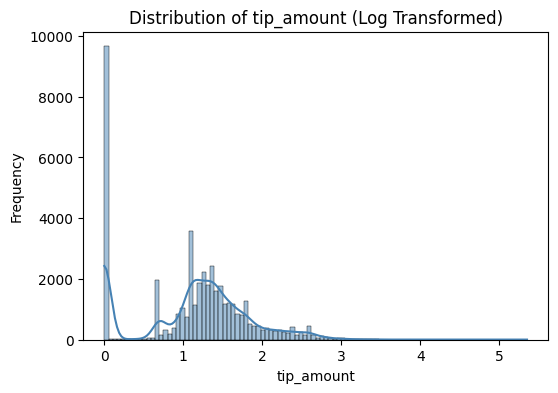

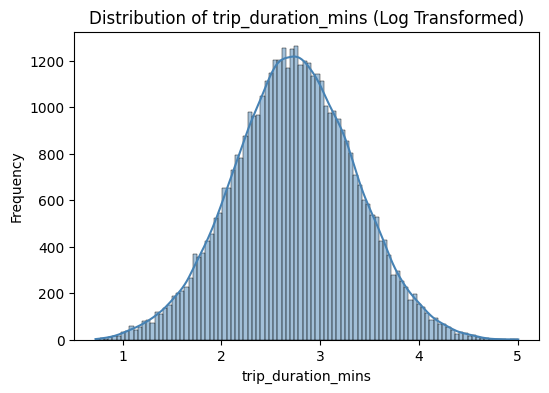

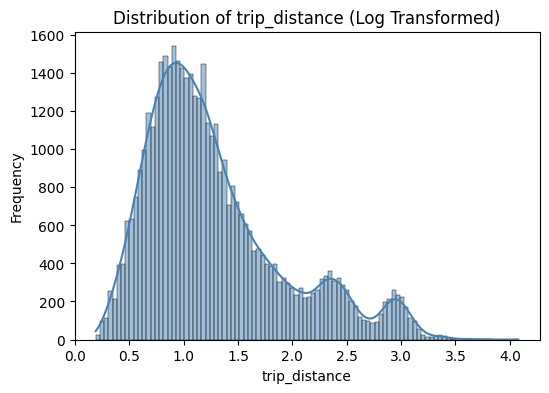

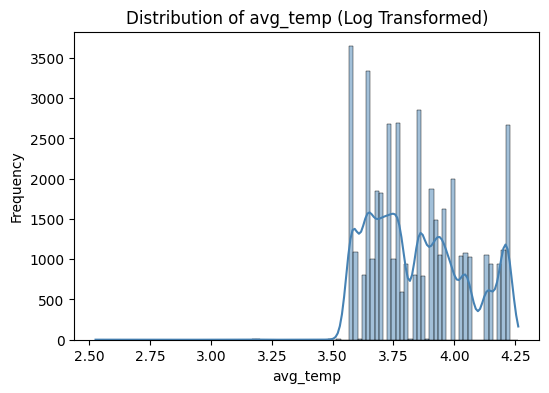

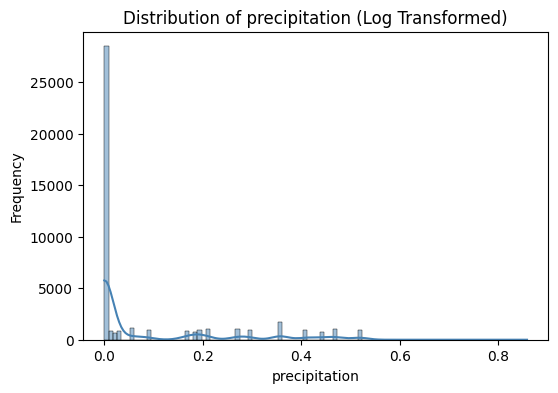

In [9]:
columns_to_plot = ['tip_amount', 'trip_duration_mins', 'trip_distance', 'avg_temp', 'precipitation']

for col_name in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col_name], bins=100, kde=True, color='steelblue')
    plt.title(f'Distribution of {col_name} (Log Transformed)')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

In [10]:
sdf_transformed.write.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development', mode='overwrite')